# Project 1: Customer Database
**This is the first of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-10-13, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements, and you should not modify the structure of the notebook**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
Your team has been hired by the company X as data scientists. X makes gadgets for a wide range of industrial and commercial clients.

As in-house data scientists, your teams first task, as per request from your new boss, is to optimize business operations. You have decided that a good first step would be to analyze the companys historical sales data to gain a better understanding of where profit is coming from. It may also reveal some low hanging fruit in terms of business opportunities.

To get started, you have called the IT department to get access to the customer and sales transactions database. To your horror you've been told that such a database doens't exist, and the only record of sales transactions is kept by John from finance in an Excel spreadsheet. So you've emailed John asking for a CSV dump of the spreadsheet...

In this project you need to clean the data you got from John, enrich it with further data, prepare a database for the data, and do some data analysis. The project is comprised of five parts. They are intended to be solved in the order they appear, but it is highly recommended that you read through all of them and devise an overall strategy before you start implementing anything.

## Part 1: Cleaning the data
John has emailed you the following link to the CSV dump you requested.

- [transactions.csv](https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv)

It seems as though he has been a bit sloppy when keeping the records. 

In this part you should:
- Explain what the data is
- Clean it to prepare it for inserting into a database and doing data analysis 

---
### Solution

In the csv file given to us by John from finances, a large table can be found. 

Each row represents a transaction from a sale of gadgets to a company. 

The file is loaded to get more information.

In [1]:
# Import libraries
import pandas as pd
import re
import requests

In [2]:
# Read csv file
df = pd.read_csv('transactions.csv', encoding='utf-8-sig')
df.head(3)

,part,company,country,city,price,date
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30


In [3]:
start_rows = len(df)
start_rows

20568

The table consists of 20568 data rows and there are 6 columns of information for each transaction. 

The first column, part, is not unique nor does it give information important in regards to doing this exercise. Therefore, it is removed from the table.

In [4]:
df.drop(['part'], inplace=True, axis=1)
df.head(3)

,company,country,city,price,date
0,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05
1,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
2,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30


To gain a better knowledge of the type of data, the first order of business is to figure out what type of data we are working with. 

In [5]:
df.dtypes

company    object
country    object
city       object
price      object
date       object
dtype: object

The above output tells us that the data in all the columns is of `object` type - also known as `str` type. However, from the table it is clear that the data in the price and date columns should not be an `object` but rather a `float` and `datetime`, respectively. 

Now that we know what the data is, we need to make a plan for how to clean it:

- Make sure that all dates in the date column are real dates and in the same format.
- Remove all the `NaN` values from company, country and city.
- Clean the price column by removing rows without a price and make sure all currencies are in euro. 
- Remove duplicates.

#### Make sure that all dates in the 'date' column are real dates and in the same format.

Firstly, we find all the transactions with the default date format (_YYYY-MM-DD_). If a transaction is not in the default format it is changed to it. Further, if a date is a non-valid date it is removed (e.g. _2017-13-32_). 

In [6]:
out_of_range = []

for i in range(0,len(df)):
    try:
        # Default format of datetime
        pd.to_datetime(df.iloc[i,4], format='%Y-%m-%d')
    except:
        try: 
            # Not default but still a valid datetime
            df.iloc[i,4] = pd.to_datetime(df.iloc[i,4])
        except:
            # Non-valid datetime.
            out_of_range.append(i)

df.drop(out_of_range, inplace=True)

We change the type from `object` to `datetime64`.

In [7]:
df['date'] = df['date'].astype('datetime64[ns]')
df.dtypes

company            object
country            object
city               object
price              object
date       datetime64[ns]
dtype: object

***SUCCES!*** All dates are now changed to the same format and the type is changed to `datetime64`.

#### Remove all the NaN values from company, country and city.

Firstly, we want to make sure that all countries are valid countries. 

We extract the latest information about current exsisting countries in the world from the external datasource: [World Bank Open Data](https://data.worldbank.org).

In [8]:
r = requests.get('http://api.worldbank.org/v2/sources/2/country/all/data?per_page=500&format=json&mrnev=1')
json_response = r.json()
res = json_response['source']

list_country = []

# Iterate to get the correct information from the json file
for r in res:    
    inner_res = r.get('concept')
    for r in inner_res:
        country = r.get('variable')
        for r in country:
            country = r.get('value')
            list_country.append(country)

A list of true countries in the world has now been generated. 

Therefore, it is very easy to see which countries from our data set stand out and might not be real countries. 

In [9]:
not_real = []
for i in range(0,len(df)):
    if df.iloc[i,1] not in list_country:
        not_real.append(df.iloc[i,1])

print(list(set(not_real)))

[nan, 'Tyskland', 'Portuga', 'US']


From the above result, it is clear that John from finances made some typos while creating his excel-file. These typos are manually changed to the correct country. 

In [10]:
for i in range(0,len(df)):
    if df.iloc[i,1] == 'US':
        df.iloc[i,1] = 'United States'
    elif df.iloc[i,1] == 'Tyskland':
        df.iloc[i,1] = 'Germany'
    elif df.iloc[i,1] == 'Portuga':
        df.iloc[i,1] = 'Portugal'

Since John from finances made typos in the country column, we wonder whether he also did the same thing in the company column. 

Unfortuneatly, no database of imagnianary companies is available so we have to be a bit creative in this exercise. 

We choose instead to count the number of times the company occurs in the dataframe and we make the assumption, that any company with a representation below or equal to 5 have to investigated further since these could be typos. 

In [11]:
counts = dict()
weird_company = []

for i in range(0,len(df)):
    if df.iloc[i,0] in counts:
        counts[df.iloc[i,0]] += 1
    else:
        counts[df.iloc[i,0]] = 1    

for char in sorted(counts.keys()):
    if counts[char] <= 5:
        weird_company.append(char)

weird_company

[' -', ' a', 'Laj0', 'Ntagz', 'Thoughtmixz', 'Zooxo.', 'aa']

From the above result, the companies listed look like possible typos. However, taking a quick glance at the dataframe with the remaining companies we see that some company names are almost identical. Thus we correct these companies to the right ones.

_Note:_ Three companies still look weird (' -', ' a' and 'aa') and so far we do not have a solution. We will deal with these later on. 

In [12]:
for i in range(0,len(df)):
    if df.iloc[i,0] == 'Zooxo.':
        df.iloc[i,0] = 'Zooxo'
    elif df.iloc[i,0] == 'Thoughtmixz':
        df.iloc[i,0] = 'Thoughtmix'
    elif df.iloc[i,0] == 'Ntagz':
        df.iloc[i,0] = 'Ntags'
    elif df.iloc[i,0] == 'Laj0':
        df.iloc[i,0] = 'Lajo' 

Now that we are sure we got rid of all of John's typos, we group each company by its country.

We assume that three cases will be present:

    (I): There is only one country for the company. In this case nothing is done. 
    (II): There is one country and one NaN value for the company. Here we replace the NaN value with the country.
    (III): There are multiple countries for the company (and possible also NaN values). This is an odd case and we have to investigate further.

In [13]:
grouped = df.groupby('company')['country'].unique().apply(list).to_dict()

still_weird_company = []

for i in range(0,len(df)):
    # If a NaN value is present
    if pd.isna(df.iloc[i,1]) == True:
        # Replace NaN value with country
        if len(grouped[df.iloc[i,0]]) == 2:
            df.iloc[i,1] = grouped[df.iloc[i,0]][0]
        # Store odd cases in list
        elif len(grouped[df.iloc[i,0]]) >= 2:
            still_weird_company.append(df.iloc[i,0])
            
list(set(still_weird_company))

['Flipstorm']

***SUCCES!*** All companies (except 'Flipstorm') now have one country and no `NaN` value.

Next step is to group each company by its country and city.

We assume that three cases will be present:

    (I): There is one country and one city for the company. In this case nothing is done. 
    (II): There is one country, one city and one NaN value for the company. In that case
    nothing is done just yet. 
    (III): There are multiple countries and/or multiple cities for this company (and 
    possible also NaN values). This is an odd case and we have to investigate further.

In [14]:
grouped = (df.groupby(['company'])['country', 'city']
       .apply(lambda x: pd.unique(x.values.ravel()).tolist()))

weird_city = []

for i in range(0,len(df)):
    # Store odd cases in list
    if len(grouped[df.iloc[i,0]]) > 3:
        if grouped[df.iloc[i,0]] in weird_city:
            pass
        else:
            weird_city.append(grouped[df.iloc[i,0]])

print(weird_city)

[['Greece', 'Athens', 'France', 'Nanterre', nan], ['Portugal', 'Braga', nan, 'Monção'], ['Portugal', 'Amadora\t', 'Vila Fria', nan]]


From above result, we see three cases that stand out from the rest.

After a quick google search we realize that John from finances once again made a mistake (_Oh John_). Vila Fria and Monção are not cities but areas and these are changed to the correct cities.

_Note:_ We also removed the extra /t from Amadora. 

Furthermore, if the country is Greece or France, the city should be Athens or Nanterre, respectively, and vice versa.

In [15]:
for i in range(0,len(df)):
    if df.iloc[i,2] == 'Amadora\t':
        df.iloc[i,2] = 'Amadora'
    elif df.iloc[i,2] == 'Vila Fria':
        df.iloc[i,2] = 'Amadora'
    elif df.iloc[i,2] == 'Monção':
        df.iloc[i,2] = 'Braga'
        
    elif df.iloc[i,1] == 'Greece':
        df.iloc[i,2] = 'Athens'
    elif df.iloc[i,1] == 'France':
        df.iloc[i,2] = 'Nanterre'
    elif df.iloc[i,2] == 'Athens':
        df.iloc[i,1] = 'Greece'
    elif df.iloc[i,2] == 'Nanterre':
        df.iloc[i,1] = 'France'

Now that this is fixed, the companies are grouped together once more.

This time we focus on all the cases where there is one country, one city and one NaN value for the company. Here we replace the NaN value with the city since we earlier made sure that there was no NaN value in the country column.

In [16]:
grouped = (df.groupby(['company'])['country', 'city']
       .apply(lambda x: pd.unique(x.values.ravel()).tolist()))

for i in range(0,len(df)):
    # If a NaN value is present
    if pd.isna(df.iloc[i,2]) == True:
        # Replace NaN value with city
        if len(grouped[df.iloc[i,0]]) == 3:
            df.iloc[i,2] = grouped[df.iloc[i,0]][1]

A sigh of relief leaves our body. _Done_, we think to ourself.

But suddenly we remember the three weird companies ' -', ' a', and 'aa'. 

We wonder if John's typos are so severe that these companies actually are some other company hidden under a typo. To check this, we see if the location of the company is identical to some of the other companies.

In [17]:
grouped = (df.groupby(['company'])['country', 'city']
       .apply(lambda x: pd.unique(x.values.ravel()).tolist()))

weird_company = ['aa',' a',' -']

for j in weird_company:
    weird = grouped[j]
    for i in range(len(grouped)):
        if grouped[i] == weird and grouped.keys()[i] not in weird_company:
            print('The company placement of "%s" matches the company "%s".' % (j, grouped.keys()[i]))

The company placement of "aa" matches the company "Wordify".
The company placement of " a" matches the company "Wordify".
The company placement of " -" matches the company "Zoonder".


Each company location only matches one other company's. Thus we make the assumption that these companies are the same. This is corrected.

In [18]:
for i in range(0,len(df)):
    if df.iloc[i,0] == 'aa':
        df.iloc[i,0] = 'Wordify'
    elif df.iloc[i,0] == ' a':
        df.iloc[i,0] = 'Wordify'
    elif df.iloc[i,0] == ' -':
        df.iloc[i,0] = 'Zoonder'

We now do a final status overview to check if everything looks good.

In [19]:
grouped = (df.groupby(['company'])['country', 'city']
       .apply(lambda x: pd.unique(x.values.ravel()).tolist()))
grouped

company
Avaveo                           [France, Nanterre]
Brainsphere                       [Portugal, Braga]
Bubblemix                            [Japan, Asaka]
Buzzbean                      [Germany, Düsseldorf]
Chatterbridge                    [Spain, Barcelona]
Eimbee                           [France, Nanterre]
Flipstorm        [Greece, Athens, France, Nanterre]
Gabcube                          [Portugal, Almada]
Gabtune                          [France, Nanterre]
Gevee                            [France, Nanterre]
Innojam                    [Netherlands, Amsterdam]
Kanoodle                           [Japan, Niihama]
Lajo                               [Greece, Athens]
Ntags                            [Portugal, Lisbon]
Realpoint                        [Portugal, Lisbon]
Rhycero                          [France, Nanterre]
Riffpath                           [Greece, Athens]
Roodel                          [Portugal, Aranhas]
Shufflebeat                       [Portugal, Porto]
Tagt

***PERFECT!!!!*** No more `NaN` values!

But suddenly we remember yesterday's news program. Some companies have been caught cheating on their taxes by locating their company in non-existing cities. 

Sleepless we dive into this task. We find a json file containing almost all countries with their respective cities: [All countries and cities](https://raw.githubusercontent.com/russ666/all-countries-and-cities-json/6ee538beca8914133259b401ba47a550313e8984/countries.json). We realize that this list is not updated often but since countries rarely change and new cities rarely arise we feel it is safe to work with this file.

We then store each country and its cities in a `dict()` and iterate our dataframe over the `dict()` to find suspicious cities.

In [23]:
r = requests.get('https://raw.githubusercontent.com/russ666/all-countries-and-cities-json/6ee538beca8914133259b401ba47a550313e8984/countries.json')
json_response = r.json()
res = json_response
res

weird_countries = {}

country_list = {}

# Store country and cities in a dict().
for r in res:
    country_list[r] = res[r]
    
for i in range(0,len(df)):
    # Iterate over the country.
    if df.iloc[i,1] in country_list.keys():
        country = str(df.iloc[i,1])
        # Iterate over the city.
        if df.iloc[i,2] not in country_list[country]:
            weird_countries[df.iloc[i,1]] = df.iloc[i,2]

print(weird_countries)

{'Germany': 'Düsseldorf', 'Portugal': 'Aranhas', 'Switzerland': 'Zürich'}


After a glance (and a google search) all our worries are put to shame. All the suspicious cities from above are real and placed in the right country. 

#### Clean the 'price' column by removing rows without a price and make sure all currencies are in euro.

After a short break and some coffee we are back at our desk ready to tackle the next task: Cleaning up the price column. 

Firtly, we want to find all the values that are not real transactions. 

In [24]:
removable = []

for i in range(0,len(df)):
    price = str(df.iloc[i,3])

    regex = re.search(r"\-?\d+\.\d{,3}", price)
        
    if regex is None:
        removable.append(price)
            
list(set(removable))

['na', 'nan', 'void', '-']

The transactions with the above words/symbols in the price column seem safe to remove and that is done.

In [25]:
remove_price = []
for index, row in df.iterrows():
    if pd.isna(row['price']) == True or row['price'] == '-' or row['price'] == 'na' or row['price'] == 'void':
        remove_price.append(index)
df.drop(remove_price, inplace = True)

For the task of cleaning up the transactions, we need to get everything in the same currency (_euro €_). 

Since exchange rates can fluctuate tremendously we need to get the correct value at the correct date. Thus we need to get our information from an external source: [Exchange rates API](http://exchangeratesapi.io).

We make a `dict()` containing all exchange rates for all available currencies from 2000 to 2019. 

In [26]:
r = requests.get('https://api.exchangeratesapi.io/history?start_at=2000-01-01&end_at=2019-10-08')
json_response = r.json()

rates = json_response['rates']

real_dates = []

for dates in rates:
    real_dates.append(dates)

Since the above exchange rates API only works with currency codes and not currency symbols we need som information from an external source in order to translate from one to the another. We use the json file: [Common currency](https://gist.githubusercontent.com/Fluidbyte/2973986/raw/b0d1722b04b0a737aade2ce6e055263625a0b435/Common-Currency.json).

In [27]:
r = requests.get('https://gist.githubusercontent.com/Fluidbyte/2973986/raw/b0d1722b04b0a737aade2ce6e055263625a0b435/Common-Currency.json')
json_response = r.json()

aDict = {}
for r in json_response: 
    aDict[json_response[r]['symbol']] = r

## TEXT MANGLER HER!!!!!!!!!

In [28]:
no_currency = []

for i in range(0,len(df)):
    try:
        original_price = df.iloc[i,3]

        regex = re.search(r"^\-?\d+\.\d{,3}\€{1}", original_price)

        if regex is not None:
            price = float(df.iloc[i,3][:-1])
            df.iloc[i,3] = round(price,2)

        elif regex is None:
            
            non_digit = re.search(r'\D',df.iloc[i,3])
            non_digit = non_digit.group(0)
            
            date = str(df.iloc[i,4])
            date = date[:-9]

            currency = aDict[non_digit]
            
            while date not in real_dates:
                date = pd.to_datetime(date)
                date = date - pd.Timedelta(days=1)
                date = str(date)
                date = date[:-9]

            rate = rates[date][currency]

            price = float(df.iloc[i,3][1:]) / rate
            df.iloc[i,3] = round(price,2)  
            
    # If the transaction do not have a currency.      
    except:
        no_currency.append(i)

# Remove if no currency attached. 
df.drop(no_currency, inplace=True)

_Note:_ If time had allowed it we would have checked from which country the dropped transactions came from and used an external database to translate from country to correct currency. 

The data in the price column is changed to `float64`.

In [29]:
df['price'] = pd.to_numeric(df['price'])
df.dtypes

company            object
country            object
city               object
price             float64
date       datetime64[ns]
dtype: object

#### Remove duplicates.

In [30]:
df = df.drop_duplicates()

#### Status.

The data has been cleaned and is now ready for further analysis. 

In [31]:
end_rows = len(df)
start_rows - end_rows

17

In total, 17 rows have been removed from the table.

---
## Part 2: Enriching the data

A common task for a data scientists is to combine or enrich data from internal sources with data available from external sources. The purpose of this can be either to fix issues with the data or to make it easier to derive insights from the data.

In this part you should enrich your data with data from at least one external source. You may look to part 4 for some  inspiration as to what is required. Your solution should be automated, i.e., you can not ask the reader of your notebook to download any data manually. You should argue why and what you expect to achieve by the enrichments you are doing.

---
### Solution

This data has been derived from The World Bank. 

## MANGLER MERE INFO: ARGUE, where is the data from etc.


In [32]:
r = requests.get('http://api.worldbank.org/v2/sources/2/country/all/series/NY.GDP.MKTP.CD/data?per_page=500&format=json&mrnev=1')
json_response = r.json()
res = json_response['source']['data']

In [33]:
list_country = []
list_value_GDP_dollar = []

counter = 0
for r in res:
    inner_res = r.get('variable')
    value = r.get('value')

    list_value_GDP_dollar.append(value)
    
    for r in inner_res:
        country = r.get('value')
        list_country.append(country)
        break

unique_country = []
for country in list_country:
    if country not in unique_country:
        unique_country.append(country)

In [34]:
r = requests.get('https://api.exchangeratesapi.io/latest?symbols=USD')
json_response = r.json()

rates = json_response['rates']['USD']

In [35]:
list_value_GDP_euro = []
for i in list_value_GDP_dollar:
    list_value_GDP_euro.append(i*rates)

In [36]:
new_df = pd.DataFrame(list(zip(unique_country,list_value_GDP_euro)), columns =['country','gdp_euro'])
new_df.head(3)

,country,gdp_euro
0,Arab World,3.068093e+12
1,Caribbean small states,8.044209e+10
2,Central Europe and the Baltics,1.799319e+12


In [37]:
df = pd.merge(df, new_df, on='country', how='inner')
df.head(3)

,company,country,city,price,date,gdp_euro
0,Chatterbridge,Spain,Barcelona,784.79,2016-01-02 00:01:05,1.573087e+12
1,Chatterbridge,Spain,Barcelona,412.55,2016-01-02 04:51:55,1.573087e+12
2,Chatterbridge,Spain,Barcelona,359.52,2016-01-02 07:20:59,1.573087e+12


In [38]:
df.dtypes

company             object
country             object
city                object
price              float64
date        datetime64[ns]
gdp_euro           float64
dtype: object

In [39]:
len(df)

20551

---
## Part 3: Creating a database
Storing data in a relational database has the advantages that it is persistent, fast to query, and it will be easier access for other employees at Weyland-Yutani.

In this part you should:
- Create a database and table(s) for the data
- Insert data into the tables

You may use SQLite locally to do this. You should argue why you choose to store your data the way you do. 

---
### Solution

In [40]:
import sqlite3

In [41]:
conn = sqlite3.connect('transactions.sqlite')

In [42]:
c = conn.cursor()

In [43]:
df.to_sql("transactions", conn, if_exists='replace')

In [44]:
conn.commit()

In [45]:
c.execute('SELECT date(date) FROM transactions')

In [46]:
len(c.fetchall())

20551

---
## Part 4: Analyzing the data
You are now ready to analyze the data. Your goal is to gain some actionable business insights to present to your boss. 

In this part, you should ask some questions and try to answer them based on the data. You should write SQL queries to retrieve the data. For each question, you should state why it is relevant and what you expect to find.

To get you started, you should prepare answers to the following questions. You should add more questions.
#### Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

#### Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.


Remember, you are taking this to your new boss, so think about how you present the data.

---
### Solution

In [47]:
sortlist = df.sort_values('company')
#sortlist

In [48]:
c.execute('SELECT company, SUM (price) FROM transactions GROUP BY company ORDER BY SUM (price) DESC;') 
c.fetchall()

[('Thoughtmix', 1624591.3000000021),
 ('Twitterbeat', 1325516.5000000028),
 ('Zooxo', 995947.1099999998),
 ('Shufflebeat', 921342.6399999998),
 ('Chatterbridge', 919349.6599999993),
 ('Ntags', 845101.6299999988),
 ('Brainsphere', 721054.1399999991),
 ('Buzzbean', 713512.9399999995),
 ('Flipstorm', 672358.2899999992),
 ('Wordify', 534993.4900000007),
 ('Yozio', 369164.51000000024),
 ('Roodel', 362927.0899999997),
 ('Eimbee', 294744.80999999976),
 ('Zoonder', 263645.72999999986),
 ('Teklist', 241354.28),
 ('Gabcube', 204584.91999999995),
 ('Voomm', 144799.98),
 ('Avaveo', 126505.0700000001),
 ('Lajo', 123085.58999999997),
 ('Rhycero', 112460.12000000004),
 ('Riffpath', 90550.25000000007),
 ('Realpoint', 85333.36999999995),
 ('Kanoodle', 72337.51999999997),
 ('Bubblemix', 27219.480000000003),
 ('Innojam', 25539.63),
 ('Gevee', 22549.16),
 ('Gabtune', 18359.269999999997),
 ('Tagtune', 6579.640000000001)]

In [104]:
c.execute('SELECT company,price,date FROM transactions GROUP BY date ORDER BY company;')

data = c.fetchall()
data
c.execute('SELECT DISTINCT company FROM transactions ORDER BY company')
companies = c.fetchall()
companies[3][0]
i=0
i=+1
i+=1
print(i)

2


yes Brainsphere ('Avaveo',)
yes Bubblemix ('Brainsphere',)
yes Buzzbean ('Bubblemix',)
yes Chatterbridge ('Buzzbean',)
yes Eimbee ('Chatterbridge',)
yes Flipstorm ('Eimbee',)
yes Gabcube ('Flipstorm',)
yes Gabtune ('Gabcube',)
yes Gevee ('Gabtune',)
yes Innojam ('Gevee',)
yes Kanoodle ('Innojam',)
yes Lajo ('Kanoodle',)
yes Ntags ('Lajo',)
yes Realpoint ('Ntags',)
yes Rhycero ('Realpoint',)
yes Riffpath ('Rhycero',)
yes Roodel ('Riffpath',)
yes Shufflebeat ('Roodel',)
yes Tagtune ('Shufflebeat',)
yes Teklist ('Tagtune',)
yes Thoughtmix ('Teklist',)
yes Twitterbeat ('Thoughtmix',)
yes Voomm ('Twitterbeat',)
yes Wordify ('Voomm',)
yes Yozio ('Wordify',)
yes Zoonder ('Yozio',)
yes Zooxo ('Zoonder',)


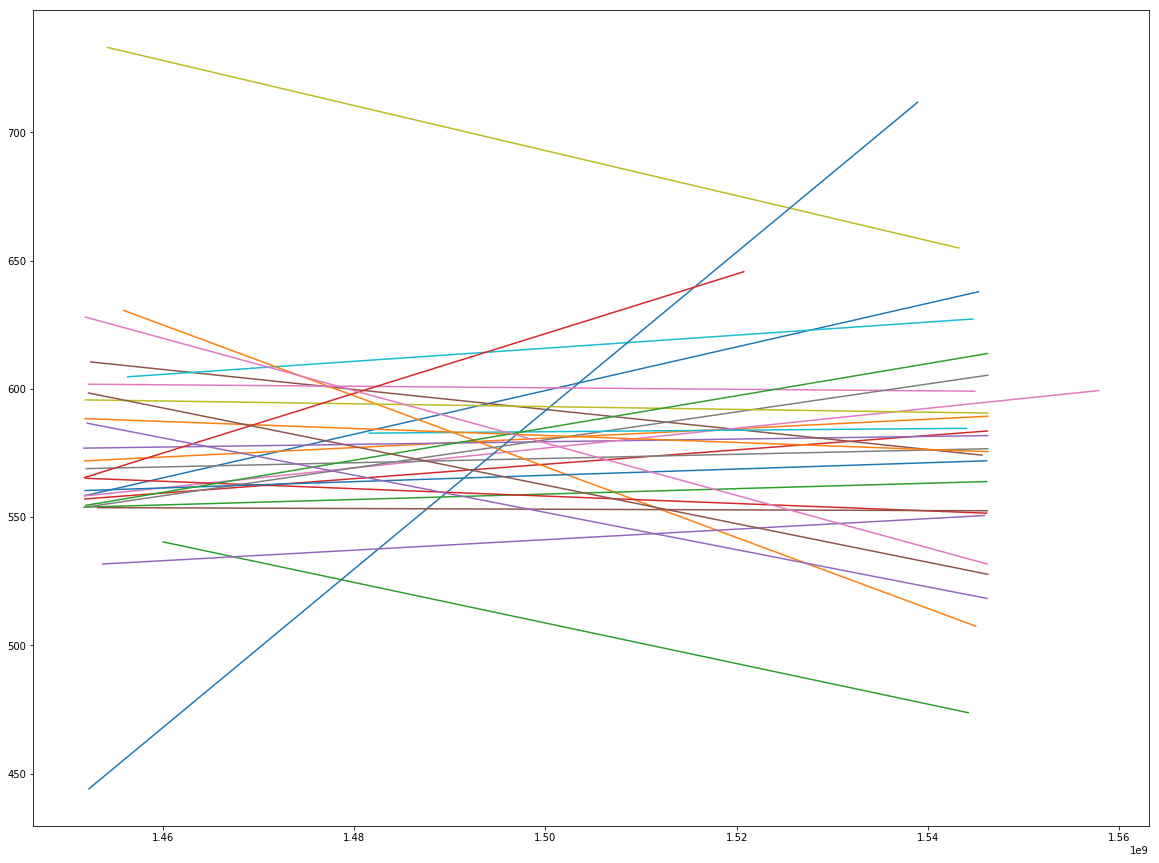

In [107]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime
import time 

plt.figure(figsize=(20,15))
        

i = 0

values = []
dates = []
for row in data:
    if row[0]==companies[i][0]:
        values.append(row[1])
        datestimes = datetime.strptime(row[2],'%Y-%m-%d %H:%M:%S')
        datestimes = datetime.timetuple(datestimes)
        dates.append(time.mktime(datestimes))
    else:
        print('yes',row[0],companies[i])
        x = np.asarray(dates).reshape((-1,1))
        y = np.asarray(values)  

        model = LinearRegression().fit(x,y)
        score = model.score(x,y)
        intercept = model.intercept_
        coef = model.coef_
        plt.plot(x,coef*x + intercept)
        i+=1
        values = []
        dates = []
    #print("Score: {}\nIntercept: {}\nCoefficient: {}\n".format(score,intercept,coef[0]))



#plt.plot(x,y,'o')
plt.show()

---
## Part 5: Performance
Your boss is very impressed with what you have achieved in less than two weeks, and he would like to take your idea of storing the customer and sales data in a relational database to production. However, John is concerned that the solution will not scale. His experience is telling him that you will see many occurrences of the following queries.

- Show all sales to company X between time $t_1$ and time $t_2$
- Show the latest X sales in the database
- Show total sales per company per day

Show that Johns concern is not justified.

---
### Solution

---